# Hong Kong Interbank Balance Plot

#### Imports

In [1]:
import pandas as pd
import requests
from requests.adapters import Retry, HTTPAdapter
from bs4 import BeautifulSoup
import json


#### Globals

In [2]:
START = '2022-01-01'
END = '2022-08-03'


#### Utility Functions

In [3]:
def url(Y, M, D):
    return (
        'https://www.hkma.gov.hk/eng/'
        'data-publications-and-research/data-and-statistics/'
        f'daily-monetary-statistics/{Y}/{M}/ms-{Y}{M}{D}/')


In [4]:
def interbank_balance(date):
    try:
        Y, M, D = date.split('-')
        sess = requests.Session()
        sess.mount('https://', HTTPAdapter(max_retries=Retry(total=50, backoff_factor=0.1)))
        resp = sess.get(url(Y, M, D))
        print(f'fetching {date}')
        soup = BeautifulSoup(resp.content)
        table = soup.select_one(
            '#interbank-liquidity + div + div div.collapsibles-accordion-content div.template-table table')
        trs = table.select('tr')
        td = trs[1].select('td')[1]
        clean_text = td.text.replace('mn', '').replace(
            '百萬', '').replace(',', '').strip()
        return float(clean_text)
    except (AttributeError, ):
        return None


#### Tests

In [5]:
for date in ['2022-06-01', '2022-07-01', '2022-08-01']:
    ib = interbank_balance(date)
    print(date, ib)


fetching 2022-06-01
2022-06-01 319990.0
fetching 2022-07-01
2022-07-01 None
fetching 2022-08-01
2022-08-01 165158.0


#### Fetch

If connection is banned, wait for a while and run this cell again. Program will only re-download failed fetch.

In [6]:
dates = [str(d.date())
         for d in pd.date_range(START, END)]
for d in dates:
    with open('cache.json', 'r') as fp:
        data = json.load(fp)
    try:
        data[d]
    except KeyError:
        data[d] = interbank_balance(d)
    with open('cache.json', 'w') as fp:
        json.dump(data, fp, indent=2)


#### Plot

<AxesSubplot:title={'center':'Hong Kong Interbank Balalnce'}, ylabel='million HKD'>

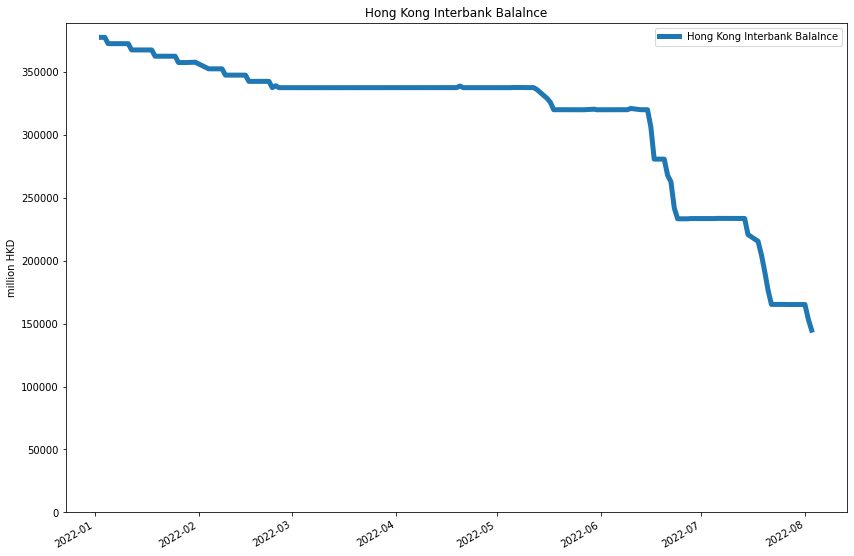

In [10]:
clean = {d:v for d,v in data.items() if v}
series = pd.Series(clean.values(),
               index=pd.to_datetime(list(clean.keys())),
               name='Hong Kong Interbank Balalnce')
series.plot(figsize=(13, 9), ylim=(0,None), title=series.name, legend=series.name, ylabel='million HKD', lw=5)
